In [1]:
import rasterio as rio
from rasterio.plot import show
import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.colors import LogNorm

from ipyleaflet import Map, Marker
import ipywidgets as widgets
import folium
from sidecar import Sidecar
import xarray
from PIL import Image

from ipyleaflet import Map, ImageOverlay, basemaps, basemap_to_tiles, WidgetControl
import pathlib, os, tempfile
from base64 import b64encode
from ipywidgets import IntSlider, SelectionSlider, VBox
from sidecar import Sidecar

In [2]:
data = rio.open('../R/test_dataset.tif')
data_bounds = (data.bounds.left, data.bounds.right, \
          data.bounds.bottom, data.bounds.top)
bounds_arr = [[data.bounds.bottom, data.bounds.left], \
                  [data.bounds.top, data.bounds.right]]
bounds_arr

[[44.90833862304688, -1.9407999999999994], [57.94833862304688, 10.4992]]

In [ ]:
# transform pixel coordinates to lat long --> create heatmap to visualize with folium
rio.transform.xy(data.transform, 0, 0)

In [ ]:
def raster_to_heatmaps(raster_ts):
    ...

In [4]:
def raster_to_pngs(raster_data, colormap=cm.rainbow):
    img_arr = raster_data.read()
    img_arr[img_arr==0] = np.nan
    img_arr = np.log(img_arr)
    img_arr = (img_arr - np.nanmin(img_arr)) / (np.nanmax(img_arr) - np.nanmin(img_arr))
    img_arr = np.uint8(colormap(img_arr)*255)
    
    os.makedirs('./png', exist_ok=True)
    
    for i in range(img_arr.shape[0]):
        im = Image.fromarray(img_arr[i])
        im.save(f'png/{i}.png','PNG')

In [5]:
raster_to_pngs(data)

In [61]:
#dataset = xarray.open_dataset('../R/test_dataset.nc')
#dataset.variables['sst']
from netCDF4 import Dataset as netcdf_dataset
dataset = netcdf_dataset('../R/test_dataset.nc')
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.5
    GDAL: GDAL 2.4.2, released 2019/06/28
    history: do mrt 12 17:26:10 2020: GDAL Create( test_dataset.nc, ... )
    dimensions(sizes): lon(1244), lat(1304)
    variables(dimensions): float32 Band1(lat,lon), float32 Band2(lat,lon), float32 Band3(lat,lon), float32 Band4(lat,lon), float32 Band5(lat,lon), float32 Band6(lat,lon), float32 Band7(lat,lon), float32 Band8(lat,lon), float32 Band9(lat,lon), |S1 crs(), float64 lat(lat), float64 lon(lon)
    groups: 

TypeError: unhashable type: 'list'

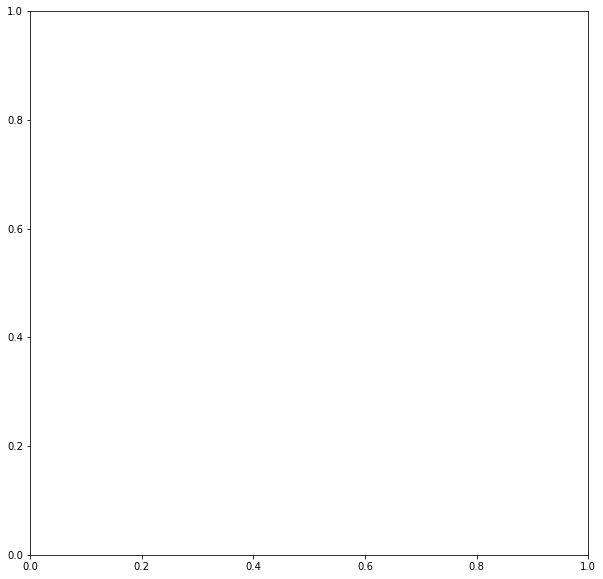

In [156]:
signal = dataset.variables['Band1'][:, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

#print(signal)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(), extent=bounds_arr)
  
signal = np.log(signal)
signal = (signal - np.nanmin(signal)) / (np.nanmax(signal) - np.nanmin(signal))

#print(signal)

plt.contourf(lons, lats, signal, 60,
             transform=ccrs.PlateCarree(), alpha=0.5)

ax.coastlines(resolution='50m')
#ax.stock_img()

sc = Slider()
with sc:
    fig.show()

In [6]:
data.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 1244,
 'height': 1304,
 'count': 9,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.01, 0.0, -1.9407999999999994,
        0.0, -0.01, 57.94833862304688)}

In [6]:
bounds=((data.bounds.bottom, data.bounds.left), \
                 (data.bounds.top, data.bounds.right))

center = ((bounds[0][0]+bounds[1][0])/2,(bounds[0][1]+bounds[1][1])/2)
m = Map(center=center, zoom=6)

time_range = range(data.read().shape[0])

slider = SelectionSlider(description='time step:', 
                   options=time_range, 
                   orientation='horizontal'
)
widget_control = WidgetControl(widget=slider, position='topright')
m.add_control(widget_control)

io = None

def display_png(idx):
    global io
    
    filename=f'png/{idx}.png'
    with open(filename, 'rb') as f:
        d = b64encode(f.read())
    d = d.decode('ascii')
    p = 'data:image/png;base64,' + d

    if io is None:
        io = ImageOverlay(url=p, bounds=bounds, opacity=0.5)
        m.add_layer(io)
    else:
        #m.remove_layer(io)
        #io = ImageOverlay(url=p, bounds=bounds, opacity=0.6)
        #m.add_layer(io)
        io.url = p
        
def show_snapshot(change):
    display_png(change.new)
        

slider.observe(show_snapshot, 'value')
display_png(0)

sc = Sidecar(title='bird vis')
with sc:
    display(m)

Map(center=[51.42833862304688, 4.2792], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

In [11]:
io.opacity

0.5

In [153]:
import cartopy.crs as ccrs

center = [51.164878, 5.295410]

img = data.read()
#img = np.random.rand(*img.shape)
img[img==0] = np.nan    
img = np.log(img)
img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img))

@widgets.interact(
    t=(0, data.read().shape[0]-1))
def plot(t=0):

    fig, ax = plt.subplots(figsize=(15,15))
    #ax = plt.axes(projection=ccrs.Mercator(central_longitude=center[0], min_latitude=data.bounds.bottom, max_latitude=data.bounds.top), extent=bounds)
    #ax.coastlines()
    
    m = ax.imshow(img[t], extent=data_bounds, interpolation='none') #ransform=ccrs.Mercator(), origin='upper',
    #ax.set(xlabel='longitude', ylabel='latitude')
    plt.colorbar(m)
    
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=8), Output()), _dom_classes=('widget-interact',)…

In [70]:
center = [51.164878, 5.295410]
m = folium.Map(location=center, tiles = 'Stamen Terrain', zoom_start = 6)

img = data.read()
img[img==0] = np.nan
#img = np.nan_to_num(img)
img = np.log(img)
img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img))

sc = Sidecar(title='Sidecar Output')
time = 0
with sc:
    #@widgets.interact(time=(0, data.read().shape[0]-1))
    #def raster_overlay(time):
        #img = np.log(img)
        #img = np.random.rand(*img.shape)
        
    folium.raster_layers.ImageOverlay(plt.cm.get_cmap('rainbow')(img[time]), opacity=0.6, bounds=bounds_arr, mercator_project=True).add_to(m)
    display(m)